### 1
•	Загрузите дневные котировки 3 акций (Apple, Google, Facebook) из открытых источников за последние 10 лет:

In [136]:
from time import sleep
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
from scipy.stats import chisquare
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from scipy.stats import kstest
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from itertools import combinations

# %matplotlib inline

In [137]:
# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
api_key = '3YMNSYCH79H1MNH7'
data={}
for s in ['AAPL','GOOG','META']:
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={s}&outputsize=full&apikey={api_key}'
    r = requests.get(url)
    data_dict = r.json()
    df = pd.DataFrame.from_dict(data_dict['Time Series (Daily)'],orient='index')
    df = pd.DataFrame(df['5. adjusted close'].astype(float))
    df.columns = ['close']
    data[s] = df
    sleep(1)

print(data.keys())

dict_keys(['AAPL', 'GOOG', 'META'])


In [138]:
data['AAPL'].head()

,close
2022-12-02,147.81
2022-12-01,148.31
2022-11-30,148.03
2022-11-29,141.17
2022-11-28,144.22


### 2
•	Посчитайте daily returns r_i   =((P_(i+1)  - P_i  ))/P_i   , где i -день, и i + 1 –след. день

In [139]:
lens=[]
for s in ['AAPL','GOOG','META']:
    data[s]['lag1'] = data[s].close.shift(-1)
    data[s]['d_r'] = (data[s].lag1 - data[s].close)/data[s].close
    data[s] = data[s].dropna()
    len_=len(data[s])
    lens.append(len_)
    print(f'len of {s}:', len_)
min_len = min(lens) 

len of AAPL: 5810
len of GOOG: 2188
len of META: 2653


In [140]:
data['AAPL'].head()

,close,lag1,d_r
2022-12-02,147.81,148.31,0.003383
2022-12-01,148.31,148.03,-0.001888
2022-11-30,148.03,141.17,-0.046342
2022-11-29,141.17,144.22,0.021605
2022-11-28,144.22,148.11,0.026973


#### Нормируем daily returns и построим плотности распределений в сравнении с gaussian distribution

AAPL median() : -0.010768386752673843
 Kolmogorov-Smirnov Test: statistic=0.0991, p-value=0.0000
GOOG median() : -0.023543501488718848
 Kolmogorov-Smirnov Test: statistic=0.0690, p-value=0.0001
META median() : -0.0293583913409073
 Kolmogorov-Smirnov Test: statistic=0.0935, p-value=0.0000


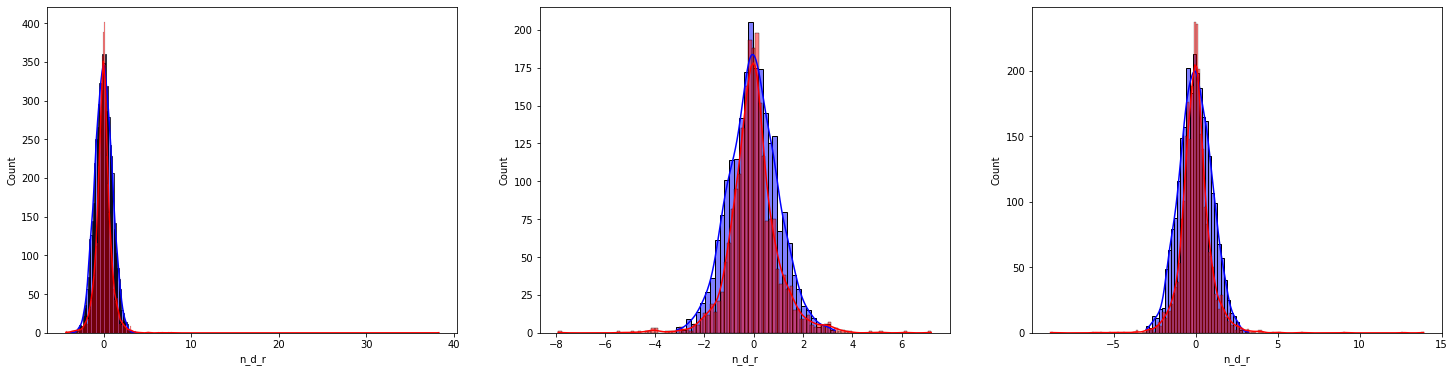

In [141]:
np.random.seed(0)


fig, axes = plt.subplots(1, 3, figsize=(25, 6))
for s, i in zip(['AAPL','GOOG','META'], range(len(['AAPL','GOOG','META']))):
    rand_gauss_value = np.random.normal(size=len(data[s]))
    data[s]['n_d_r'] = StandardScaler().fit_transform(data[s].d_r.values.reshape(-1,1)).squeeze()
    sns.histplot(rand_gauss_value, kde=True, ax=axes.flat[i], color = 'blue')
    sns.histplot(data[s].n_d_r, kde=True, ax=axes.flat[i], color = 'red')
   
    print(s + ' median() :', data[s]['n_d_r'].median())    
    stat, p_value = kstest(data[s]['n_d_r'], rand_gauss_value)
    print(f" Kolmogorov-Smirnov Test: statistic={stat:.4f}, p-value={p_value:.4f}")

#### Выводы
1. У всех трех акций можно отметить небольшое значение positive skewness (mean>median), что указывает на бОльшую частоту крупных просадок цен, чем это должно было быть при нормальном распределении.
2. У всех трех акций имеется kurtois, или "тяжелые хвосты", опять же свидетельствующие о более частых (чем "положено") аномальных движениях. 
3. В тесте Колмогорова-Смирнова у всех трех акций p-value <<<1% поэтому с высокой достоверностью отвергаем нулевую гипотезу об одинаковости двух распределений.

Вообще подбор вида распределений цен на фондовом рынке - тема поднимаемая в эконометрической литературе уже много десятилетий. 
Суть одна - строить модели на гипотезе о нормально распределенных доходностях надо как минимум с осторожностью...

#### Посмотрим визульно на ряды и проведем тест adfuller на стационарность

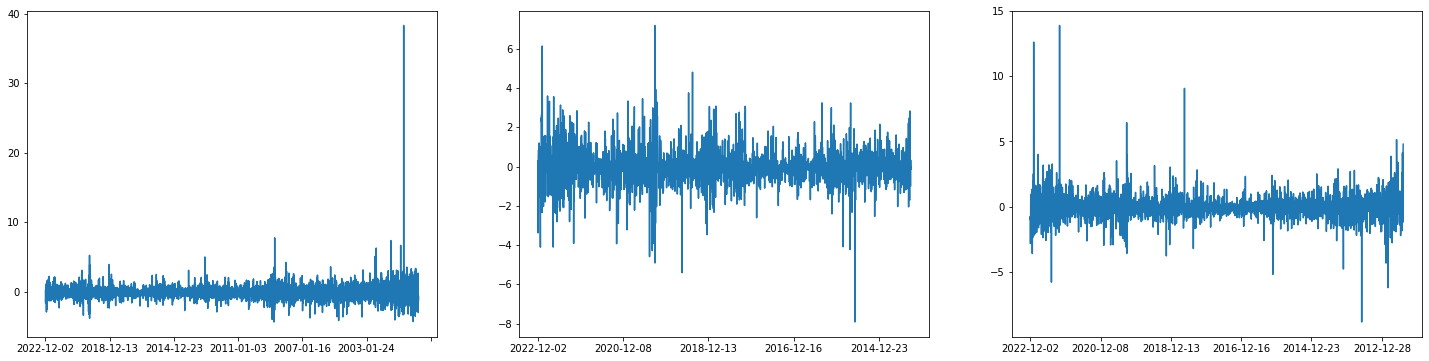

In [142]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))
for s, i in zip(['AAPL','GOOG','META'], range(len(['AAPL','GOOG','META']))):
    data[s]['n_d_r'].plot(ax=axes.flat[i])

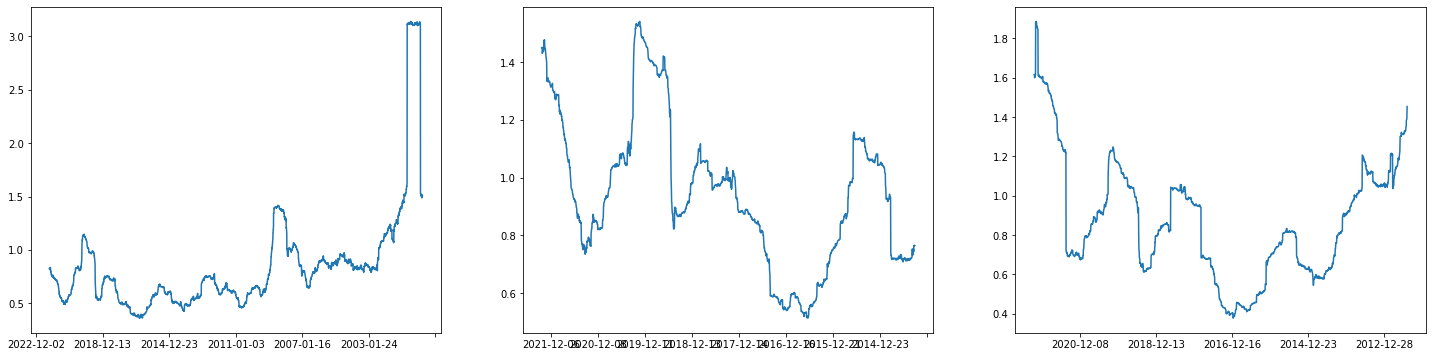

In [143]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))
for s, i in zip(['AAPL','GOOG','META'], range(len(['AAPL','GOOG','META']))):
    data[s]['n_d_r'].rolling(200).std().plot(ax=axes.flat[i])

#### Визуально не видно сезонных или трендовых явлений. Однако можно отметить колебания скользящей волатильности, что свидетельствует скорее о нетационарности этих рядов. Есть также несколько аномальных значений. Хотя тестирование скорее всего покажет стационарность.

In [144]:
for s in ['AAPL','GOOG','META']:
    test = adfuller(data[s]['d_r'])
    print('adf: ', test[0])
    print('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0] > test[4]['1%']:  # проверка, больше ли критического полученное значение для нашего ряда
        print(f'Ряд дневных доходностей {s} НЕ стационарен')
    else:
        print(f'Ряд дневных доходностей {s} cтационарен')
    print('-----------------------------------------------')    

adf:  -15.751665582643888
p-value:  1.221235601396624e-28
Critical values:  {'1%': -3.4314806953877275, '5%': -2.8620396600349722, '10%': -2.5670359670726235}
Ряд дневных доходностей AAPL cтационарен
-----------------------------------------------
adf:  -10.47231095265926
p-value:  1.2749377052886702e-18
Critical values:  {'1%': -3.4333670748168506, '5%': -2.8628728385507474, '10%': -2.567479536622141}
Ряд дневных доходностей GOOG cтационарен
-----------------------------------------------
adf:  -15.472861219552161
p-value:  2.616088026310614e-28
Critical values:  {'1%': -3.432827541597229, '5%': -2.862634590579131, '10%': -2.5673526885729334}
Ряд дневных доходностей META cтационарен
-----------------------------------------------


#### Ряды доходностей можно считать стационарными в соответствии с тестом adfuller. Однако учитывая колебания оценочной дисперсии - распределения доходностей этих акции нельзя считать стационарными на всем рассматриваемом интервале.

•	Есть ли взаимосвязь между прошлыми и будущими значениями временного ряда для отдельно выбранной акции? Если да, то значима ли она (для 1 акции)?

#### Посмотрим на самое простое - наличие линейной взаимосвязи с прошлыми значениями с помощью функций автокорреляции и частичной автокорреляции

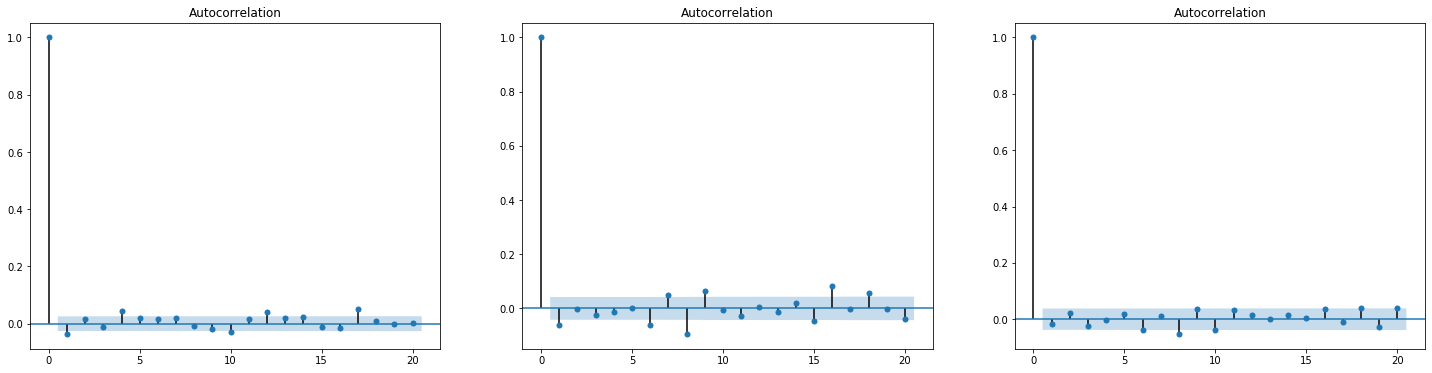

In [145]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))
for s, i in zip(['AAPL','GOOG','META'], range(len(['AAPL','GOOG','META']))):
    plot_acf(data[s]['d_r'].values,lags=20,ax=axes.flat[i])

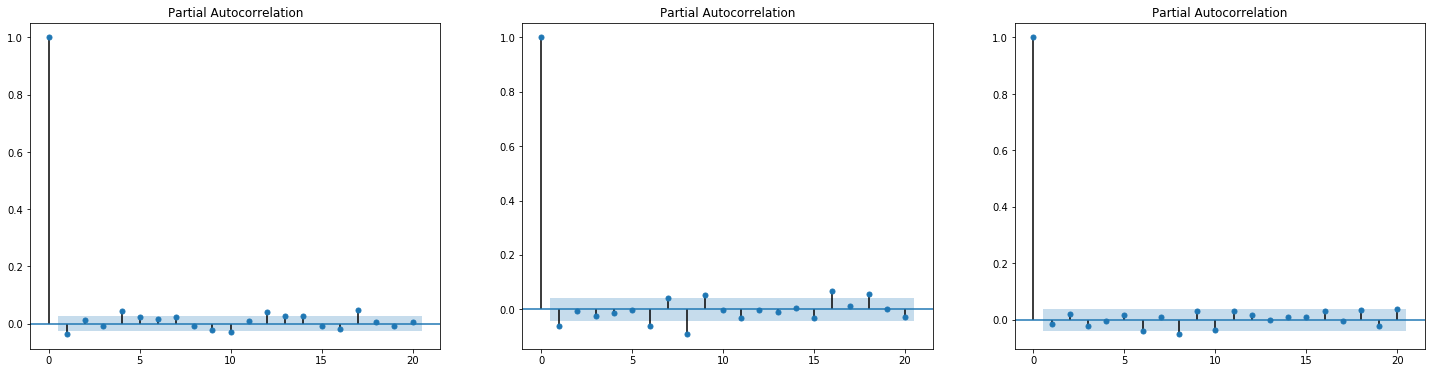

In [146]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))
for s, i in zip(['AAPL','GOOG','META'], range(len(['AAPL','GOOG','META']))):
    plot_pacf(data[s]['d_r'].values,lags=20,ax=axes.flat[i])

#### Выводы
Графики АКФ и частичной АКФ свидетельствуют об очень слабых взаимосвязях между прошлыми и будущими значениями рядов. У Apple  и Google можно отметить слабую отрицательную корреляцию с предыдущим значением доходности. Также можно отметить еще несколько лагов, где значение функций АКФ выходит за пределы доверительных интервалов (закрашенная область), что могло бы формально свидетельствовать о значимости этих значений, однако эти значения относительно небольшие. И в целом, применение этих функций требует предварительной стационарности рядов, что, как правило, не соблюдается на фондовом рынке.

•	Есть ли интересные взаимосвязи между return-ами  различных инструментов в один и тот же период по времени? (Предположение: поиск корреляции, Granger causality, PCA decomposition of returns)

#### Построим попарные scatterplot и корреляции рядов

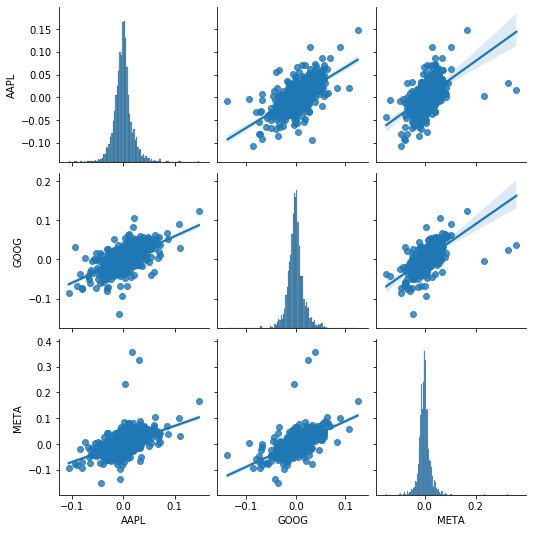

In [147]:
tmp_df = pd.DataFrame()
for s in ['AAPL','GOOG','META']:
    tmp_df[s] = data[s]['d_r'][:min_len]
sns.pairplot(tmp_df,kind='reg')  


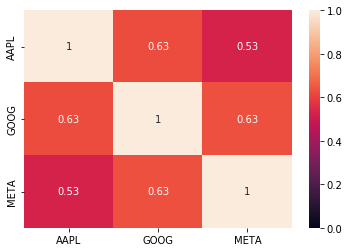

In [148]:
sns.heatmap(tmp_df.corr().abs(), annot=True, vmin=0, vmax=1)

#### Построим функции ВКФ

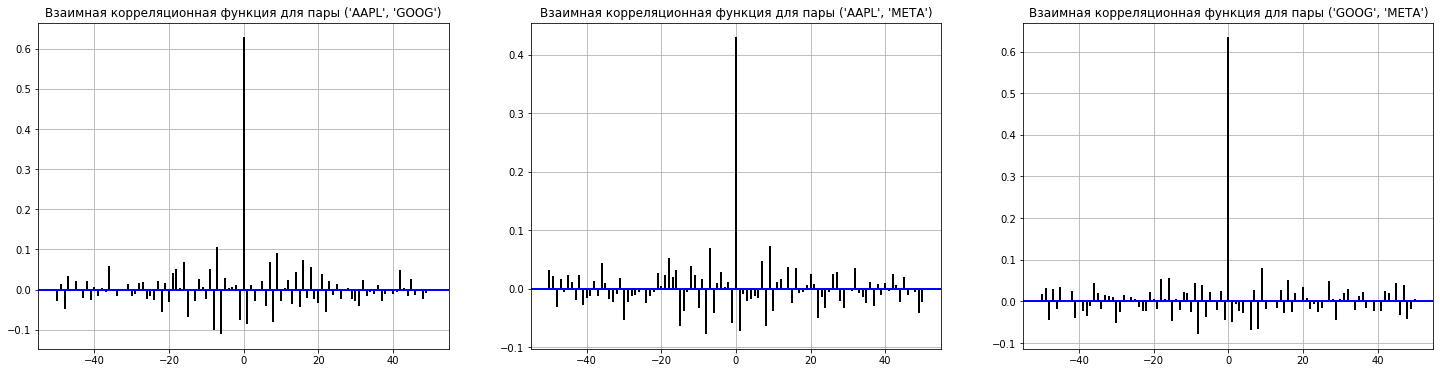

In [149]:
combs = combinations(['AAPL','GOOG','META'], 2)
fig, axes = plt.subplots(1, 3, figsize=(25, 6))
for i,k in enumerate(list(combs)):


    x = data[k[0]]['d_r'].values
    y = data[k[1]]['d_r'].values

    len_=min(len(x),len(y))
    x=x[:len_]
    y=y[:len_]

    # Plot graph
#     fig = plt.figure()
    ax1 = axes.flat[i] #fig.add_subplot(211)
    ax1.set_title(f"Взаимная корреляционная функция для пары {k}")
    # cross correlation using
    # xcorr() function
    ax1.xcorr(x, y, usevlines=True,
              maxlags=50, normed=True,
              lw=2)
    # adding grid to the graph
    ax1.grid(True)
    ax1.axhline(0, color='blue', lw=2)
#     ax1.set_title = 'sdf'
    # show final plotted graph
plt.show()

#### В целом можно отметь очевидную взаимосвязь между текущими доходностями акций. Влияние прошлых значений на будущие несущественно.

### 3
Предположим, каждый день вы получаете предсказание   f_i величины r_i
Введем понятие Profit-and-loss (pnl) для каждого дня
pnl_i  = f_i   * r_i
Пусть f_i имеет распределение standard Gaussian с mean = 0 и std = 1. 
Задача: Сгенерируйте несколько случайных реализаций f_i, постройте графики pnl_i  и pnl = cumsum(pnl_i)


#### Выполним задание, например, для Apple.

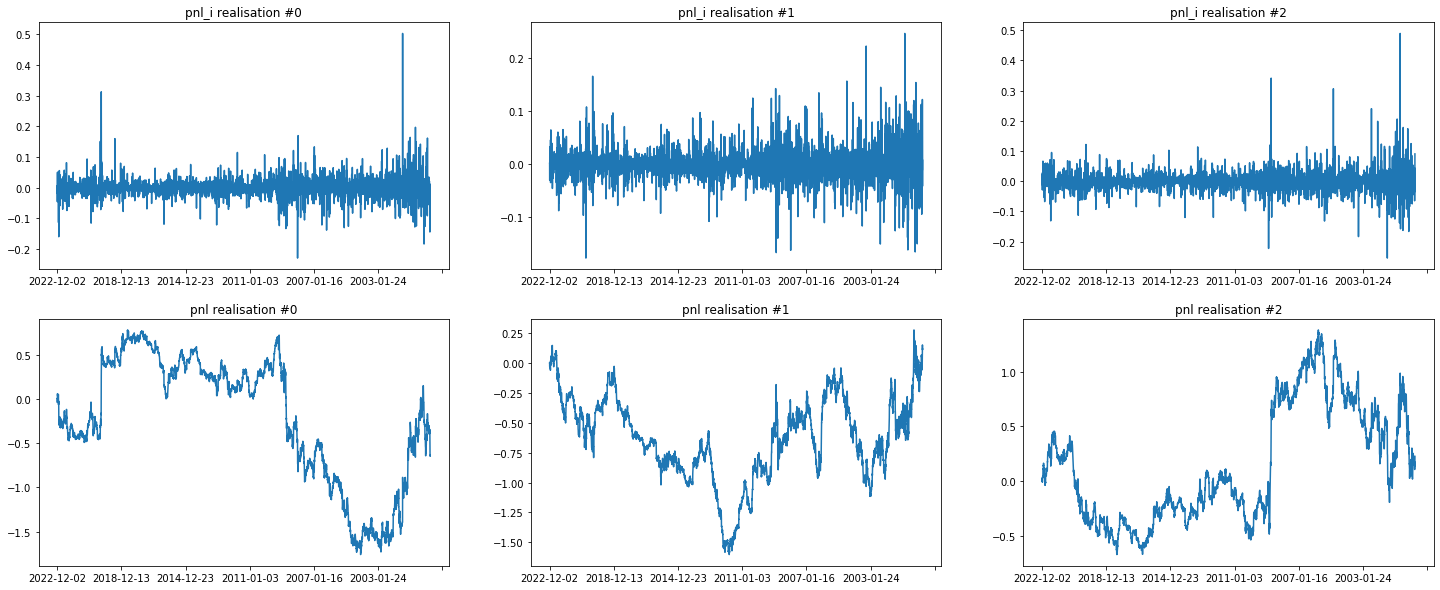

In [150]:
s = 'AAPL'
fig, axes = plt.subplots(2, 3, figsize=(25, 10))
rand_seeds = [0,42,43]
for i,r in enumerate(rand_seeds):
    np.random.seed(r)
    f = np.random.normal(size=len(data[s]))
    data[s]['pnl_i'] = f*data[s]['d_r']
    data[s]['pnl'] = data[s]['pnl_i'].cumsum()
    data[s]['pnl_i'].plot(ax=axes.flat[i], title = f'pnl_i realisation #{i}')
    data[s]['pnl'].plot(ax=axes.flat[i+len(rand_seeds)],title = f'pnl realisation #{i}')

### 4
Для временного ряда (например, доходностей) коэффициент Sharpe Ratio определяется как SR = E [pnl_i ]/√(V[pnl_i ] )
Представьте, что каждый день вы делаете случайное предсказание f_i  согласно стандартному распределению для конкретной акции. Качество ваших предсказаний можно охарактеризовать с помощью
 hit rate =1/n  *(∑_i▒〖 I(sign(f_i) == sign(r_i)))〗  
Hit rate - это мера точности: то, как часто наш прогноз совпадает по направлению движения акции .
f_i  это случайная величина, имеющая множество реализаций 
Постройте scatter plot SR(pnl_i) от hit rate в диапазоне от 0 до 1


<function matplotlib.pyplot.show(*args, **kw)>

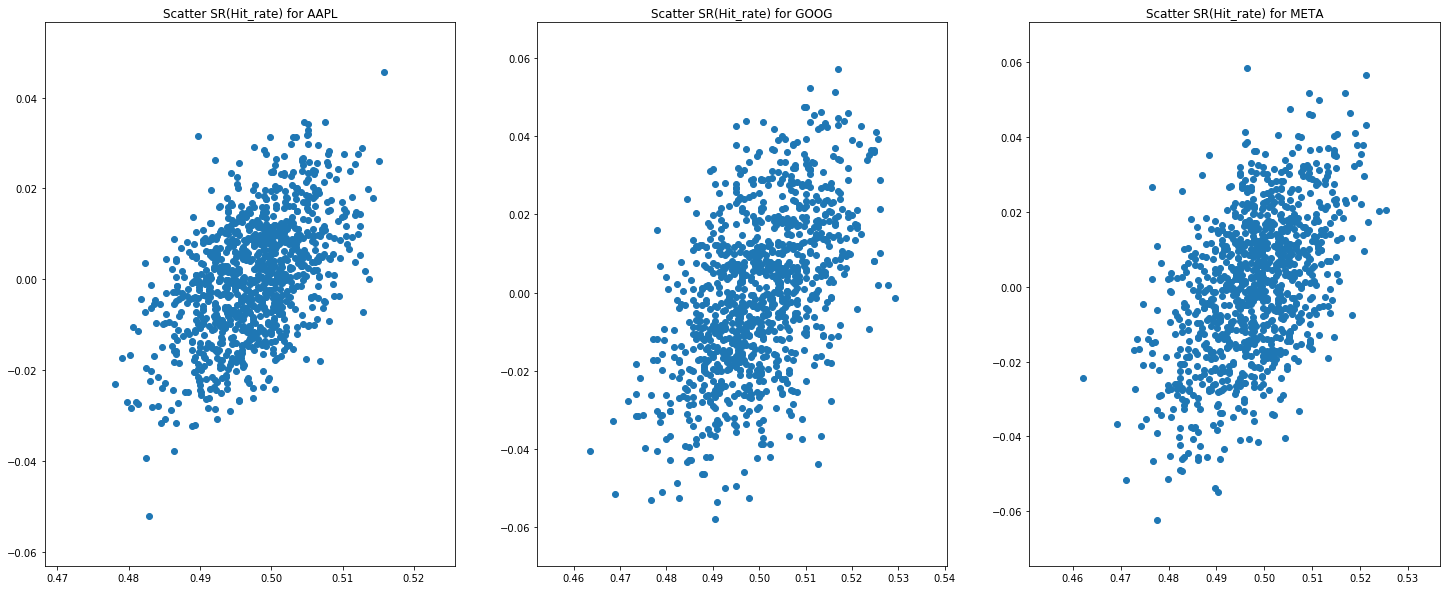

In [151]:
#Sharpe_Ratio = portf_val[‘Daily Return’].mean() / portf_val[‘Daily Return’].std()
fig, axes = plt.subplots(1, 3, figsize=(25, 10))
np.random.seed(42)

stats = {}
for i,s in enumerate(['AAPL','GOOG','META']):
    stats[s] = {}
    stats[s]['SR'] = []
    stats[s]['Hit_rate'] = []
for i,s in enumerate(['AAPL','GOOG','META']):    
    for k in range(1000):
        f = np.random.normal(size=len(data[s]))

        data[s]['pnl_i'] = f*data[s]['d_r']
        data[s]['pnl'] = data[s]['pnl_i'].cumsum()

        SR_k = data[s]['pnl_i'].mean()/data[s]['pnl_i'].std()
    #     print(SR_k)
        stats[s]['SR'].append(SR_k)
        HR_k = np.mean(np.sign(f)==np.sign(data[s]['d_r']))
    #     print(HR_k)
        stats[s]['Hit_rate'].append(HR_k)
#   plt.title()
    
    ax1 = axes.flat[i]
    ax1.set_title(f"Scatter SR(Hit_rate) for {s}")
    ax1.scatter(stats[s]['Hit_rate'], stats[s]['SR'] )
    
plt.show

#### 5
Постройте модель классификации на представленных данных и заполните пустые значения.

In [152]:
df = pd.read_csv('xtask.csv')

In [153]:
df

,a,b,c,d,class
0,-0.233408,-0.845698,0.365256,0.311292,1.0
1,0.073524,-0.747284,0.586381,0.303840,1.0
2,0.105561,-0.749805,0.149815,0.635771,1.0
3,-0.642419,-0.342424,-0.608454,0.229135,0.0
4,0.296581,-0.656553,0.022429,0.639708,0.0
...,...,...,...,...,...
3834,-0.926398,0.171996,-0.333049,0.035802,NaN
3835,0.787500,-0.355948,0.425932,-0.200971,NaN
3836,0.282760,-0.569896,-0.231674,0.735929,NaN
3837,-0.599582,-0.749842,0.265262,-0.088739,NaN


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3839 entries, 0 to 3838
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a       3839 non-null   float64
 1   b       3839 non-null   float64
 2   c       3839 non-null   float64
 3   d       3839 non-null   float64
 4   class   3071 non-null   float64
dtypes: float64(5)
memory usage: 150.1 KB


In [155]:
df.describe()

,a,b,c,d,class
count,3839.000000,3839.000000,3839.000000,3839.000000,3071.00000
mean,0.000237,-0.001918,-0.005020,0.017286,0.65972
std,0.492286,0.493000,0.489641,0.504631,0.47388
min,-0.995371,-0.996342,-0.996055,-0.998084,0.00000
25%,-0.394078,-0.395845,-0.395307,-0.386948,0.00000
50%,-0.008509,-0.010900,-0.015388,0.015544,1.00000
75%,0.399061,0.395606,0.382006,0.436341,1.00000
max,0.995987,0.993865,0.988428,0.997183,1.00000


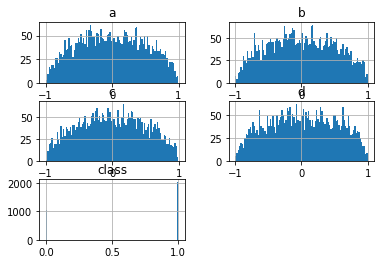

In [156]:
for i in [df.columns]:
    df[i].hist(bins=100)

#### Все признаки находятся в диапазоне (0,1) и видимо одинаково распределены. Целевая переменная - бинарная. Класс 1 встречается в два раза чаще класса 0.

In [163]:
df_ = df[df['class'].notna()]

#### Построим попарные scatterplot и корреляции рядов

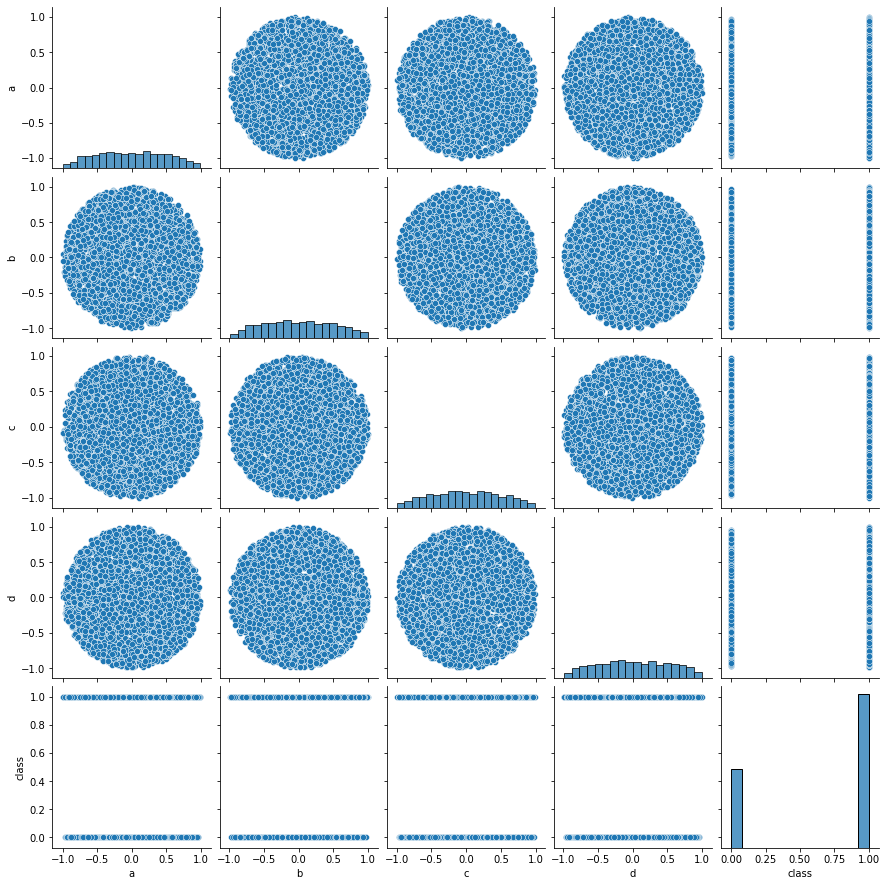

In [158]:
sns.pairplot(df_)

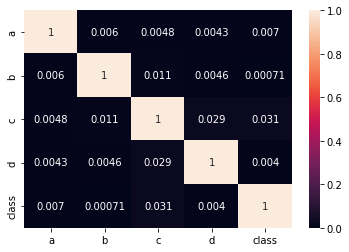

In [164]:
sns.heatmap(df_.corr().abs(), annot=True, vmin=0, vmax=1)

#### Вывод
Можно предположить попарную независимость между признаками и целевой переменной. Единственной информацией похоже остается распределение целевой переменной. Исходя из того, что класс 1 более частый, то наилучшим предсказанием будет просто всегда предсказывать 1. Фактически мы применяем Наивный байесовский классификатор. "В тех редких случаях, когда признаки действительно независимы (или почти независимы), наивный байесовский классификатор (почти) оптимален" (http://www.machinelearning.ru/wiki/index.php?title=%D0%9D%D0%B0%D0%B8%D0%B2%D0%BD%D1%8B%D0%B9_%D0%B1%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80).

In [165]:
X = df[df['class'].notna()].drop(columns=['class'])
y = df[df['class'].notna()]['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

In [166]:
y_pred = np.ones(len(y_test))

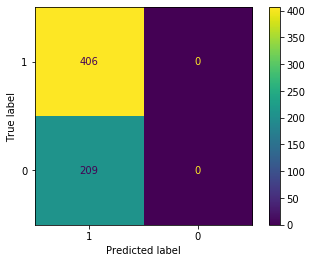

,Метрика,Значение
0,accuracy,0.660163
1,precision,0.660163
2,recall,1.000000
3,f1_score,0.795299


In [167]:
def get_metrics(y_true,y_pred,labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)
    disp.plot()
    plt.show()
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    value = [accuracy_score(y_true, y_pred), precision_score(
        y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)]
    display(pd.DataFrame(
        {'Метрика': metrics, 'Значение': value}, columns=['Метрика', 'Значение']))
    return

get_metrics(y_test,y_pred,labels = [1,0])

#### Повторим с моделью naive_bayes из sklearn

In [73]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

In [108]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 615 points : 209


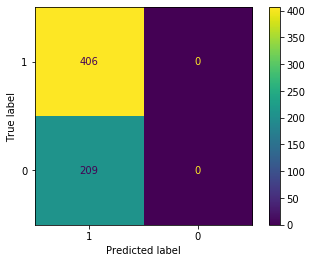

,Метрика,Значение
0,accuracy,0.660163
1,precision,0.660163
2,recall,1.000000
3,f1_score,0.795299


In [168]:
def get_metrics(y_true,y_pred,labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)
    disp.plot()
    plt.show()
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    value = [accuracy_score(y_true, y_pred), precision_score(
        y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)]
    display(pd.DataFrame(
        {'Метрика': metrics, 'Значение': value}, columns=['Метрика', 'Значение']))
    return

get_metrics(y_test,y_pred,labels = [1,0])

#### Результаты естественно одинаковые: y_pred == 1

In [181]:
# Сохраним ответ в файл
test_length = len(df[df['class'].isna()])
y_pred = np.ones(test_length)
pd.Series().to_csv('Y_test.csv',index=False, header=False)